In [55]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from ggplot import *

RND_STATE = 51834
%matplotlib inline
sns.set_style("whitegrid")

## 1. Loading data

### 1.1 Data load from file

In [2]:
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)

In [3]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


### 1.1 Data exploration

| Variable Name | Description | Type |
| :- | :- | :- |
| SeriousDlqin2yrs | Person experienced 90 days past due delinquency or worse | Y/N |
| RevolvingUtilizationOfUnsecuredLines | Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits | percentage |
| age | Age of borrower in years | integer |
| NumberOfTime30-59DaysPastDueNotWorse | Number of times borrower has been 30-59 days past due but no worse in the last 2 years. | integer |
| DebtRatio | Monthly debt payments, alimony,living costs divided by monthy gross income | percentage |
| MonthlyIncome | Monthly income | real |
| NumberOfOpenCreditLinesAndLoans | Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards) | integer |
| NumberOfTimes90DaysLate | Number of times borrower has been 90 days or more past due. | integer |
| NumberRealEstateLoansOrLines | Number of mortgage and real estate loans including home equity lines of credit | integer |
| NumberOfTime60-89DaysPastDueNotWorse | Number of times borrower has been 60-89 days past due but no worse in the last 2 years. | integer |
| NumberOfDependents | Number of dependents in family excluding themselves (spouse, children etc.) | integer |






### 1.2 Checking if classes are imbalanced

In [4]:
def plotClassBalance(classesData):
    ax = sns.countplot(x = classesData)
    ax.set_title('Dataset class balance check')
    ax.set_xlabel('Person experienced 90 days past due delinquency or worse ')
    ax.set_ylabel('Count')
    plt.show()

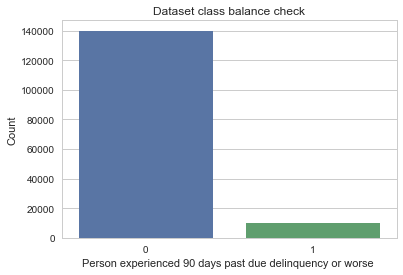

In [5]:
plotClassBalance(data.SeriousDlqin2yrs)

### 1.3 Checking for NAN values

In [6]:
def checkDataFrameNANs(df):
    print('Number of nans by property:')
    print(df.isnull().sum())

In [7]:
checkDataFrameNANs(data)

Number of nans by property:
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


## 2. Data preprocessing

### 2.1 Working with NANs

#### 2.1.1 Working with NumberOfDependents parameter 

Рассматриваемый датасет содержит пропуски в параметре NumberOfDependents. Пропусков достаточно немного, и, чтобы не удалять значения, заменим пропуски в данных медианными значениями.

In [8]:
data['NumberOfDependents'].fillna(data['NumberOfDependents'].median(), inplace = True)

#### 2.1.2 Working with MonthlyIncome parameter 

В используемом датасете очень много пустых значений параметра MonthlyIncome. 
Построим линейную регрессию для восстановления значений параметра.

In [9]:
non_null_data_monInc = data[data.MonthlyIncome.isnull() == False]
null_monInc = data[data.MonthlyIncome.isnull() == True]

monInc_y_train = non_null_data_monInc.MonthlyIncome
monInc_X_train = non_null_data_monInc.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis = 1)
null_monInc = null_monInc.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis=1)

monIncLR = LinearRegression(fit_intercept=True, normalize=True).fit(monInc_X_train, monInc_y_train)

С помощью полученной модели предскажем значения параметра для NAN значений 

In [10]:
monInc_y_pred = monIncLR.predict(null_monInc)
monInc_y_pred[monInc_y_pred < 0] = 0
null_monInc['MonthlyIncome'] = monInc_y_pred

In [11]:
monNew = []
for index in data.index:
    if data.MonthlyIncome[index].is_integer() == True:
        monNew.append(data.MonthlyIncome[index])
    else:
        monNew.append(null_monInc.MonthlyIncome[index])
data.MonthlyIncome = monNew

#### 2.1.3 Cheking for NANs again

In [12]:
print('Number of nans by property:')
checkDataFrameNANs(data)

Number of nans by property:
Number of nans by property:
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


### 2.2 Train test split

In [13]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data.SeriousDlqin2yrs

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = RND_STATE)

### 2.3 Oversampling minor class

Train subset balance before oversampling

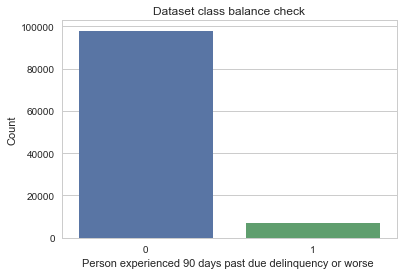

In [15]:
plotClassBalance(y_train)

In [16]:
sm = SMOTE(random_state = RND_STATE)
X_res, y_res = sm.fit_sample(X_train, y_train)

And after oversampling

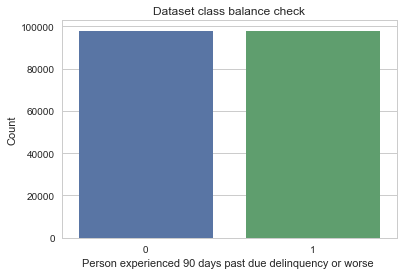

In [17]:
plotClassBalance(y_res)

In [18]:
X_train = X_res.copy()
y_train = y_res.copy()

## 3. Data prediction

### 3.1 Building models

#### 3.1.1 Gradient Boosting

In [19]:
folds = StratifiedKFold(n_splits = 10, random_state = RND_STATE, shuffle = False)
#создаем объект класса GradientBoostingClassifier() с определенным набором параметров
gb = GradientBoostingClassifier(learning_rate = 0.1, subsample = 0.7,  
                                max_features = 'sqrt', random_state = RND_STATE)
#устанавливаем диапозон параметров для скользящего контроля
gb_params = {'loss': ['deviance', 'exponential'],
             'min_samples_leaf': [2, 3, 4, 5], 
             'n_estimators': [150], 'random_state' : [RND_STATE]}
#создаем объект класса GridSearchCV()
gb_cv = GridSearchCV(gb, param_grid = gb_params, scoring = 'roc_auc', cv = folds, n_jobs = -1, verbose = 1)
#обучаемся на обучающей выборке
gb_cv.fit(X_train, y_train)
#делаем предсказание меток класса на тестовой
gb_cv_predict = gb_cv.predict(X_test)
#делаем предсказание вероятности класса на тестовой
gb_cv_predict_proba = gb_cv.predict_proba(X_test)[:, 1]
#вычисляем значение метрики 
roc_auc_gb = roc_auc_score(y_test, gb_cv_predict_proba)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 30.8min finished


In [20]:
print("ROC AUC score:", roc_auc_gb,
      "CV best score:", gb_cv.best_score_)

ROC AUC score: 0.853971358188 CV best score: 0.982407618682


In [21]:
fpr, tpr, thresholds = roc_curve(y_test, gb_cv_predict_proba)
print("ROC AUC score:", auc(fpr, tpr))

ROC AUC score: 0.853971358188


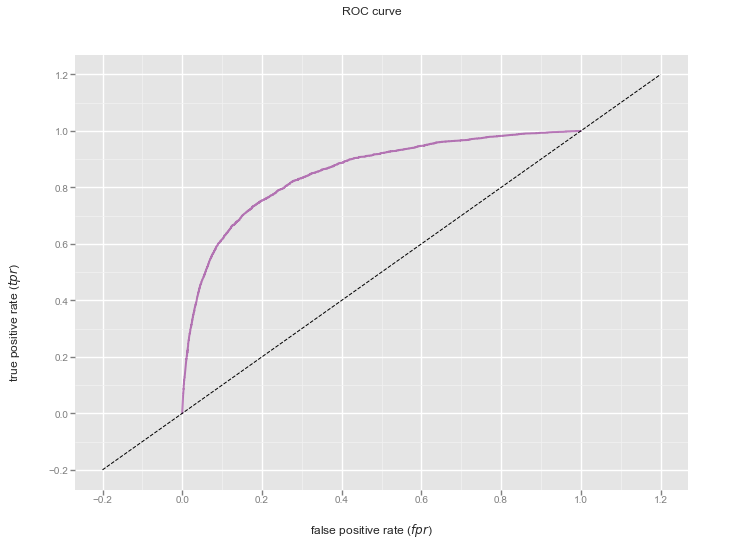

<ggplot: (287337697)>

In [22]:
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y ='tpr')) +\
    geom_line(color='purple', size = 2, alpha = 0.5) +\
    geom_abline(linetype = 'dashed') +\
    xlab("false positive rate ($fpr$)") + ylab("true positive rate ($tpr$)") + ggtitle("ROC curve")

In [23]:
importances_gb = gb_cv.best_estimator_.feature_importances_ #получение весов признаков
print(str("Топ - 5 важнейших признаков:") + '\n')
gb_zip = zip(X.columns, importances_gb) 
for a, b, in sorted(gb_zip, key = lambda zp_gb: zp_gb[1], reverse = True)[:5]:
    print("{0}: {1}".format(a, b))

Топ - 5 важнейших признаков:

NumberOfDependents: 0.2176126946934697
NumberRealEstateLoansOrLines: 0.2040648349815809
NumberOfTime30-59DaysPastDueNotWorse: 0.17091956664381647
RevolvingUtilizationOfUnsecuredLines: 0.09555064095296614
NumberOfTimes90DaysLate: 0.09551357801255474


#### 3.1.2 Random Forest

In [24]:
#количество n_splits было увеличено, чтобы избежать переобучения
folds = StratifiedKFold(n_splits = 25, random_state = RND_STATE) 
#набор параметров
params = {'criterion': ['gini', 'entropy'], 
         'max_features': [1, 5, 10, 'log2', 'auto'],
         'max_depth': [2, 4, 8, 16, 32], 
         'class_weight': ['balanced'], 'random_state' : [RND_STATE]}
#создание объекта класса GridSearchCV()
rf_cv = GridSearchCV(RandomForestClassifier(), params, 
                     scoring='roc_auc', n_jobs = -1, cv = folds, verbose = 1)
#обучение модели
rf_cv.fit(X_train, y_train)
#предсказание меток класса
rf_cv_prediction = rf_cv.predict(X_test)
#предсказание вероятности принадлежности к одному из классов
rf_cv_prediction_proba = rf_cv.predict_proba(X_test)[:, 1]
#вычисляем значение метрики 
roc_auc_rf = roc_auc_score(y_test, rf_cv_prediction_proba)

Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 46.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 86.5min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed: 87.1min finished


In [25]:
print("ROC AUC score:", roc_auc_rf,
      "CV best score:", rf_cv.best_score_)

ROC AUC score: 0.800069249985 CV best score: 0.987153913602


In [26]:
fpr, tpr, thresholds = roc_curve(y_test, rf_cv_prediction_proba)
print("ROC AUC score:", auc(fpr, tpr))

ROC AUC score: 0.800069249985


In [27]:
print("ROC AUC score:", auc(fpr, tpr))

ROC AUC score: 0.800069249985


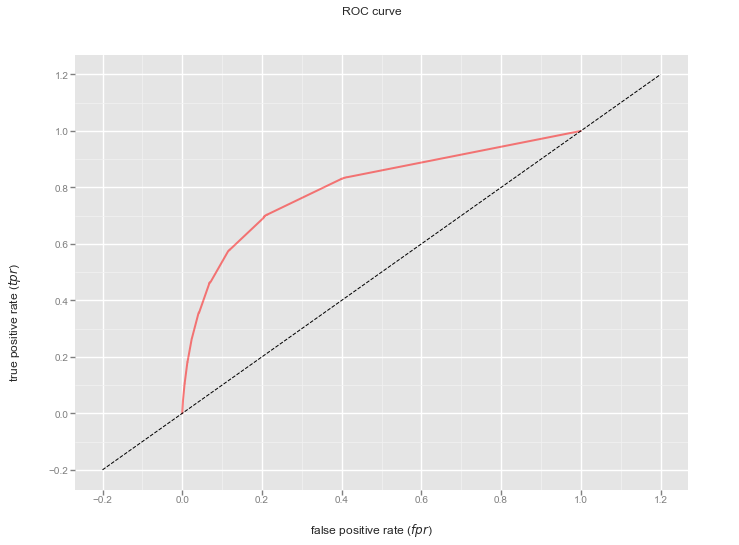

<ggplot: (287210851)>

In [28]:
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y ='tpr')) +\
    geom_line(color='red', size = 2, alpha = 0.5) +\
    geom_abline(linetype = 'dashed') +\
    xlab("false positive rate ($fpr$)") + ylab("true positive rate ($tpr$)") + ggtitle("ROC curve")

In [29]:
importances_rf = rf_cv.best_estimator_.feature_importances_ #получение весов признаков
print(str("Топ - 5 важнейших признаков:") + '\n')
rf_zip = zip(X.columns, importances_rf) 
for a, b, in sorted(rf_zip, key = lambda zp_rf: zp_rf[1], reverse = True)[:5]:
    print("{0}: {1}".format(a, b))

Топ - 5 важнейших признаков:

RevolvingUtilizationOfUnsecuredLines: 0.17455612509785937
NumberOfTimes90DaysLate: 0.15245190978654402
NumberOfTime30-59DaysPastDueNotWorse: 0.14697929024345238
NumberOfTime60-89DaysPastDueNotWorse: 0.10731836441566904
NumberRealEstateLoansOrLines: 0.08743540967243424


#### 3.1.3 Logistic Regression

In [30]:
#создаем объект класса XGBClassifier() с определенным набором параметров
lr = LogisticRegression(class_weight = 'balanced', random_state = RND_STATE)
#устанавливаем диапозон параметров для скользящего контроля
lr_params = {'penalty': ['l1', 'l2'], 
             'C': [0.5, 0.8, 1.0], 'random_state' : [RND_STATE]}
#создаем объект класса GridSearchCV()
lr_cv = GridSearchCV(lr, param_grid = lr_params, scoring = 'roc_auc', cv = folds, n_jobs = -1, verbose = 1)
#обучаемся на обучающей выборке
lr_cv.fit(X_train, y_train)
#делаем предсказание меток класса на тестовой
lr_cv_predict = lr_cv.predict(X_test)
#делаем предсказание вероятности класса на тестовой
lr_cv_predict_proba = lr_cv.predict_proba(X_test)[:, 1]
#вычисляем значение метрики 
roc_auc_lr = roc_auc_score(y_test, lr_cv_predict_proba)

Fitting 25 folds for each of 6 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.5min finished


In [31]:
print("ROC AUC score:", roc_auc_lr,
      "CV best score:", lr_cv.best_score_)

ROC AUC score: 0.79943139677 CV best score: 0.834023590548


In [32]:
fpr, tpr, thresholds = roc_curve(y_test, lr_cv_predict_proba)
print("ROC AUC score:", auc(fpr, tpr))

ROC AUC score: 0.79943139677


In [33]:
print("ROC AUC score:", auc(fpr, tpr))

ROC AUC score: 0.79943139677


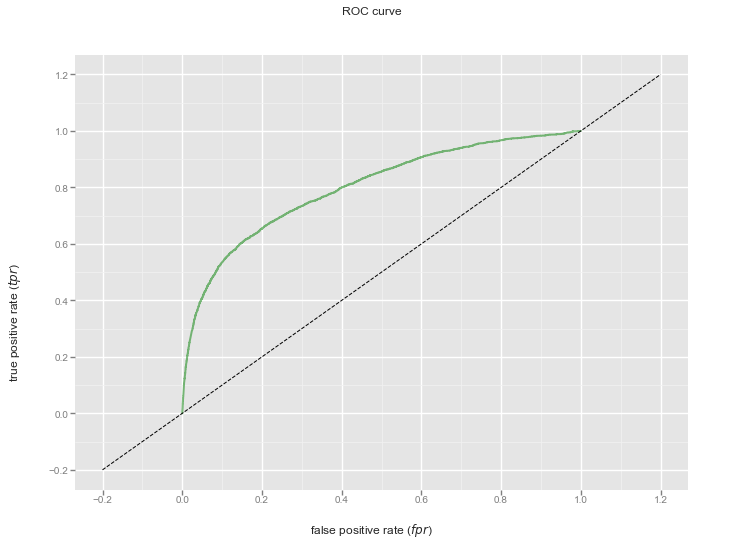

<ggplot: (287094329)>

In [34]:
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y ='tpr')) +\
    geom_line(color='green', size = 2, alpha = 0.5) +\
    geom_abline(linetype = 'dashed') +\
    xlab("false positive rate ($fpr$)") + ylab("true positive rate ($tpr$)") + ggtitle("ROC curve")

In [35]:
importances_lr = lr_cv.best_estimator_.coef_.flatten()
print(str("Топ - 5 важнейших признаков:") + '\n')
lr_zip = zip(X.columns, importances_lr) 
for a, b, in sorted(lr_zip, key = lambda zp_lr: zp_lr[1], reverse = True)[:5]:
    print("{0}: {1}".format(a, b))

Топ - 5 важнейших признаков:

NumberOfTimes90DaysLate: 0.7235590625922033
NumberOfTime30-59DaysPastDueNotWorse: 0.6687871101117892
NumberRealEstateLoansOrLines: 0.09328844307009083
NumberOfDependents: 0.08751915098800242
NumberOfTime60-89DaysPastDueNotWorse: 0.07774494259863379


#### 3.1.4 Adaboost classifier

In [36]:
#устанавливаем диапозон параметров для скользящего контроля
params = {'base_estimator__criterion' : ["gini", "entropy"],
          'base_estimator__splitter' :   ["best", "random"],
          'n_estimators': [1, 2]}

dtc = DecisionTreeClassifier(random_state = RND_STATE, max_features = "auto", 
                             class_weight = "balanced", max_depth = None)

ab = AdaBoostClassifier(base_estimator = dtc)

#создаем объект класса GridSearchCV()
ab_cv = GridSearchCV(ab, param_grid=params, scoring = 'roc_auc', verbose = 1)
#обучаемся на обучающей выборке
ab_cv.fit(X_train, y_train)
#делаем предсказание меток класса на тестовой
ab_cv_predict = ab_cv.predict(X_test)
#делаем предсказание вероятности класса на тестовой
ab_cv_predict_proba = ab_cv.predict_proba(X_test)[:, 1]
#вычисляем значение метрики 
roc_auc_ab = roc_auc_score(y_test, ab_cv_predict_proba)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   45.0s finished


In [37]:
print("ROC AUC score:", roc_auc_ab,
      "CV best score:", ab_cv.best_score_)

ROC AUC score: 0.692117573273 CV best score: 0.962779577752


In [38]:
fpr, tpr, thresholds = roc_curve(y_test, ab_cv_predict_proba)
print("ROC AUC score:", auc(fpr, tpr))

ROC AUC score: 0.692117573273


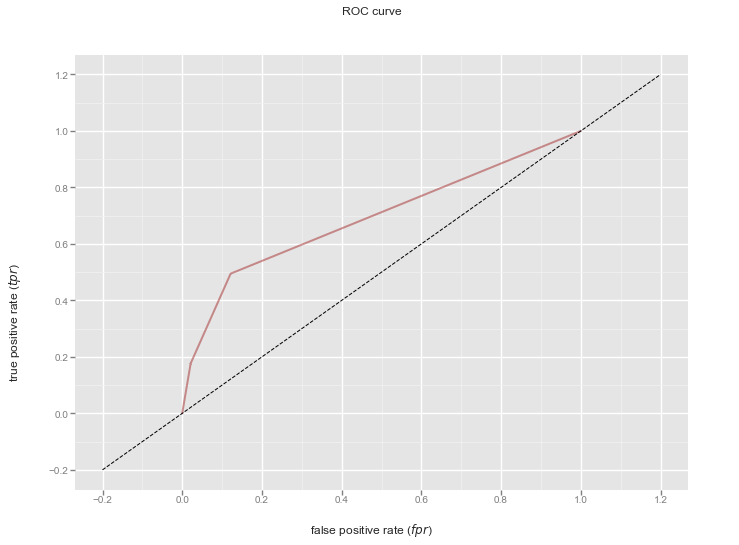

<ggplot: (288177910)>

In [39]:
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y ='tpr')) +\
    geom_line(color='brown', size = 2, alpha = 0.5) +\
    geom_abline(linetype = 'dashed') +\
    xlab("false positive rate ($fpr$)") + ylab("true positive rate ($tpr$)") + ggtitle("ROC curve")

In [40]:
importances_ab = ab_cv.best_estimator_.feature_importances_ #получение весов признаков
print(str("Топ - 5 важнейших признаков:") + '\n')
ab_zip = zip(X.columns, importances_ab) 
for a, b, in sorted(ab_zip, key = lambda zp_ab: zp_ab[1], reverse = True)[:5]:
    print("{0}: {1}".format(a, b))

Топ - 5 важнейших признаков:

NumberOfTime30-59DaysPastDueNotWorse: 0.23753960427544216
NumberRealEstateLoansOrLines: 0.12383757082943242
NumberOfTime60-89DaysPastDueNotWorse: 0.10189610843940572
NumberOfTimes90DaysLate: 0.10167546496313908
NumberOfOpenCreditLinesAndLoans: 0.0946181469855846


#### 3.1.5 Decision Trees classifier

In [41]:
#устанавливаем диапозон параметров для скользящего контроля
params = {'criterion': ['gini', 'entropy'], 
         'max_features': [1, 5, 10, 'log2', 'auto'],
         'max_depth': [2, 4, 8, 16, 32], 
         'random_state' : [RND_STATE]}

dt = DecisionTreeClassifier(random_state = RND_STATE, class_weight ='balanced')

#создаем объект класса GridSearchCV()
dt_cv = GridSearchCV(dt, param_grid=params, scoring = 'roc_auc', verbose = 1)
#обучаемся на обучающей выборке
dt_cv.fit(X_train, y_train)
#делаем предсказание меток класса на тестовой
dt_cv_predict = dt_cv.predict(X_test)
#делаем предсказание вероятности класса на тестовой
dt_cv_predict_proba = dt_cv.predict_proba(X_test)[:, 1]
#вычисляем значение метрики 
roc_auc_dt = roc_auc_score(y_test, dt_cv_predict_proba)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.1min finished


In [42]:
print("ROC AUC score:", roc_auc_dt,
      "CV best score:", dt_cv.best_score_)

ROC AUC score: 0.83413447118 CV best score: 0.966347475232


In [43]:
fpr, tpr, thresholds = roc_curve(y_test, dt_cv_predict_proba)
print("ROC AUC score:", auc(fpr, tpr))

ROC AUC score: 0.83413447118


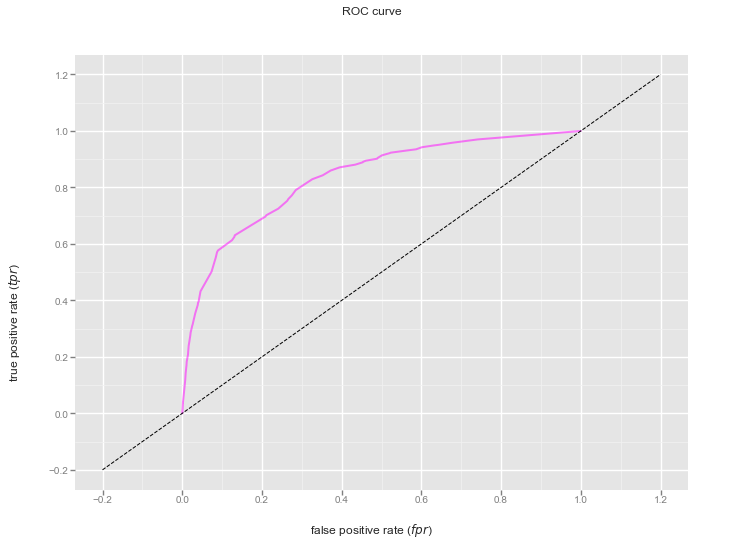

<ggplot: (298343828)>

In [44]:
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y ='tpr')) +\
    geom_line(color='magenta', size = 2, alpha = 0.5) +\
    geom_abline(linetype = 'dashed') +\
    xlab("false positive rate ($fpr$)") + ylab("true positive rate ($tpr$)") + ggtitle("ROC curve")

In [45]:
importances_dt = dt_cv.best_estimator_.feature_importances_ #получение весов признаков
print(str("Топ - 5 важнейших признаков:") + '\n')
dt_zip = zip(X.columns, importances_dt) 
for a, b, in sorted(dt_zip, key = lambda zp_dt: zp_dt[1], reverse = True)[:5]:
    print("{0}: {1}".format(a, b))

Топ - 5 важнейших признаков:

NumberOfTime30-59DaysPastDueNotWorse: 0.5608777223371707
NumberOfTimes90DaysLate: 0.1998254800701682
NumberOfDependents: 0.08156742117443229
RevolvingUtilizationOfUnsecuredLines: 0.07369460117153466
NumberOfTime60-89DaysPastDueNotWorse: 0.06047178044068172


#### 3.1.6 KNeighborsClassifier

In [46]:
#устанавливаем диапозон параметров для скользящего контроля
knn_params = {'n_neighbors': np.arange(1, 31, 2),
              'metric': ['euclidean', 'cityblock']}

knn = KNeighborsClassifier()

#создаем объект класса GridSearchCV()
knn_cv = GridSearchCV(knn, param_grid=knn_params, scoring = 'roc_auc', verbose = 1)
#обучаемся на обучающей выборке
knn_cv.fit(X_train, y_train)
#делаем предсказание меток класса на тестовой
knn_cv_predict = knn_cv.predict(X_test)
#делаем предсказание вероятности класса на тестовой
knn_cv_predict_proba = knn_cv.predict_proba(X_test)[:, 1]
#вычисляем значение метрики 
roc_auc_knn = roc_auc_score(y_test, knn_cv_predict_proba)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 81.1min finished


In [47]:
print("ROC AUC score:", roc_auc_knn,
      "CV best score:", knn_cv.best_score_)

ROC AUC score: 0.609467062617 CV best score: 0.947897145697


In [48]:
fpr, tpr, thresholds = roc_curve(y_test, knn_cv_predict_proba)
print("ROC AUC score:", auc(fpr, tpr))

ROC AUC score: 0.609467062617


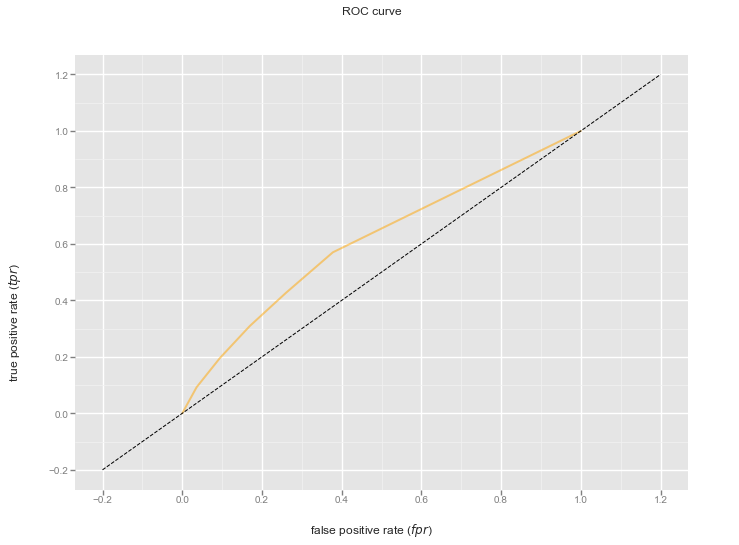

<ggplot: (296388023)>

In [49]:
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y ='tpr')) +\
    geom_line(color='orange', size = 2, alpha = 0.5) +\
    geom_abline(linetype = 'dashed') +\
    xlab("false positive rate ($fpr$)") + ylab("true positive rate ($tpr$)") + ggtitle("ROC curve")

#### 3.1.7 SVC

In [50]:
#создаем объект класса SVC()
folds = StratifiedKFold(n_splits = 10, random_state = RND_STATE, shuffle = False)
svc = SVC(random_state = RND_STATE, cache_size=2048, class_weight='balanced')
#устанавливаем диапозон параметров для скользящего контроля
svc_params = {'kernel': ['linear', 'poly', 'rbf'], 
             'decision_function_shape': ['ovo', 'ovr']}
#создаем объект класса GridSearchCV()
svc_cv = GridSearchCV(svc, param_grid = svc_params, scoring = 'roc_auc', cv = folds, n_jobs = -1, verbose = 1)
#обучаемся на обучающей выборке
svc_cv.fit(X_train, y_train)
#делаем предсказание меток класса на тестовой
svc_cv_predict = svc_cv.predict(X_test)
#делаем предсказание вероятности класса на тестовой
svc_cv_predict_proba = svc_cv.predict_proba(X_test)[:, 1]
#вычисляем значение метрики 
roc_auc_svc = roc_auc_score(y_test, svc_cv_predict_proba)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


KeyboardInterrupt: 

In [ ]:
print("ROC AUC score:", roc_auc_svc,
      "CV best score:", svc_cv.best_score_)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, svc_cv_predict_proba)
print("ROC AUC score:", auc(fpr, tpr))

In [ ]:
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y ='tpr')) +\
    geom_line(color='grey', size = 2, alpha = 0.5) +\
    geom_abline(linetype = 'dashed') +\
    xlab("false positive rate ($fpr$)") + ylab("true positive rate ($tpr$)") + ggtitle("ROC curve")

In [ ]:
importances_svc = svc_cv.best_estimator_.feature_importances_ #получение весов признаков
print(str("Топ - 5 важнейших признаков:") + '\n')
svc_zip = zip(X.columns, importances_svc) 
for a, b, in sorted(svc_zip, key = lambda zp_svc: zp_svc[1], reverse = True)[:5]:
    print("{0}: {1}".format(a, b))

#### 3.1.8 XGBoost

In [ ]:
#создаем объект класса XGBClassifier() с определенным набором параметров
xgb = XGBClassifier(learning_rate = 0.1, n_estimators = 150, 
                            max_delta_step = 1.5, min_child_weight = 1, 
                            gamma = 0, colsample_bytree = 0.5, subsample = 0.78,
                            objective= 'binary:logistic', scale_pos_weight = 1, seed = RND_STATE)
#устанавливаем диапозон параметров для скользящего контроля
xgb_params = {'max_depth': [3, 4, 5, 6, 8], 
              'colsample_bytree': [0.5, 0.8]}
#создаем объект класса GridSearchCV()
xgb_cv = GridSearchCV(xgb, param_grid = xgb_params, scoring = 'roc_auc', cv = folds, verbose=1)
#обучаемся на обучающей выборке
xgb_cv.fit(X_train, y_train)
#делаем предсказание меток класса на тестовой
xgb_cv_predict = xgb_cv.predict(X_test)
#делаем предсказание вероятности класса на тестовой
xgb_cv_predict_proba = xgb_cv.predict_proba(X_test)[:, 1]
#вычисляем значение метрики 
roc_auc_xgb = roc_auc_score(y_test, xgb_cv_predict_proba)

In [ ]:
print("ROC AUC score:", roc_auc_xgb,
      "CV best score:", xgb_cv.best_score_)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, xgb_cv_predict_proba)
print("ROC AUC score:", auc(fpr, tpr))

In [ ]:
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y ='tpr')) +\
    geom_line(color='magenta', size = 2, alpha = 0.5) +\
    geom_abline(linetype = 'dashed') +\
    xlab("false positive rate ($fpr$)") + ylab("true positive rate ($tpr$)") + ggtitle("ROC curve")

In [ ]:
importances_mlp = xgb_cv.best_estimator_.feature_importances_ #получение весов признаков
print(str("Топ - 5 важнейших признаков:") + '\n')
xgb_zip = zip(X.columns, importances_xgb) 
for a, b, in sorted(xgb_zip, key = lambda zp_xgb: zp_xgb[1], reverse = True)[:5]:
    print("{0}: {1}".format(a, b))

#### 3.1.9 MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
#создание объекта класса RandomForestClassifier, устанавливая балансировку классов
mlp = MLPClassifier() 
#установление набора параметров
mlp_params = {'activation' : ['identity', 'logistic', 'tanh', 'relu'],
              'solver': {'lbfgs'', 'sgd', 'adam'},
              'hidden_layer_sizes': np.arange(1, 4)}
    
#создание объекта класса GridSearchCV
mlp_cv = GridSearchCV(mlp, mlp_params, scoring = 'accuracy')
#обучение 
mlp_cv.fit(X_train, y_train)
#обучаемся на обучающей выборке
mlp_cv.fit(X_train, y_train)
#делаем предсказание меток класса на тестовой
mlp_cv_predict = mlp_cv.predict(X_test)
#делаем предсказание вероятности класса на тестовой
mlp_cv_predict_proba = mlp_cv.predict_proba(X_test)[:, 1]
#вычисляем значение метрики 
roc_auc_mlp = roc_auc_score(y_test, mlp_cv_predict_proba)

In [ ]:
print("ROC AUC score:", roc_auc_mlp,
      "CV best score:", mlp_cv.best_score_)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, mlp_cv_predict_proba)
print("ROC AUC score:", auc(fpr, tpr))

In [ ]:
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y ='tpr')) +\
    geom_line(color='black', size = 2, alpha = 0.5) +\
    geom_abline(linetype = 'dashed') +\
    xlab("false positive rate ($fpr$)") + ylab("true positive rate ($tpr$)") + ggtitle("ROC curve")

In [ ]:
importances_mlp = mlp_cv.best_estimator_.feature_importances_ #получение весов признаков
print(str("Топ - 5 важнейших признаков:") + '\n')
mlp_zip = zip(X.columns, importances_mlp) 
for a, b, in sorted(mlp_zip, key = lambda zp_mlp: zp_mlp[1], reverse = True)[:5]:
    print("{0}: {1}".format(a, b))

#### 3.10 Voting clf

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

#clf1 = LogisticRegression(random_state = 1)
clf1 = gb_cv.best_estimator_
clf2 = rf_cv.best_estimator_
clf3 = knn_cv.best_estimator_

voting = VotingClassifier(estimators=[('gb', clf1), ('rf', clf2), ('knn', clf3)])

v_params = {'voting': ['soft']}

voting_cv = GridSearchCV(voting, param_grid = v_params, scoring = 'roc_auc', cv = folds)

voting_cv.fit(X_train, y_train)

voting_cv_predict = voting_cv.predict(X_test)

#делаем предсказание вероятности класса на тестовой
voting_cv_predict_proba = mlp_cv.predict_proba(X_test)[:, 1]
#вычисляем значение метрики 
roc_auc_voting = roc_auc_score(y_test, voting_cv_predict_proba)

In [ ]:
print("ROC AUC score:", roc_auc_voting,
      "CV best score:", voting_cv.best_score_)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, voting_cv_predict_proba)
print("ROC AUC score:", auc(fpr, tpr))

In [ ]:
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y ='tpr')) +\
    geom_line(color='blue', size = 2, alpha = 0.5) +\
    geom_abline(linetype = 'dashed') +\
    xlab("false positive rate ($fpr$)") + ylab("true positive rate ($tpr$)") + ggtitle("ROC curve")

In [ ]:
importances_voting = voting_cv.best_estimator_.feature_importances_ #получение весов признаков
print(str("Топ - 5 важнейших признаков:") + '\n')
voting_zip = zip(X.columns, importances_voting) 
for a, b, in sorted(voting_zip, key = lambda zp_voting: zp_voting[1], reverse = True)[:5]:
    print("{0}: {1}".format(a, b))

### results

1. ROC AUC score: 0.853971358188 gb
2. ROC AUC score: 0.800069249985 rf
3. ROC AUC score: 0.83413447118 dt
4. ROC AUC score: 0.687102056134 ada
5. ROC AUC score: 0.79943139677 lr
6. ROC AUC score: 0.609480240747 knn
7.
8.
9.
10.